In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym


In [2]:
class RandomWalker1D:
    def __init__(self, loc=0.1, sd=0.02):
        self.state = torch.tensor([[0.0], [1.0]], dtype=torch.float)
        self.loc = loc
        self.sd = sd


        pass
    def step(self, a:int):
        noise = torch.normal(self.loc, self.sd, size=(1,), dtype=torch.float)
        if a == 0:
            next_pos = self.state[0, 0] + noise
        elif a == 1:
            next_pos = self.state[0, 0] - noise
        else:
            raise ValueError('a needs to be either integer 1 or 0.')
        terminated = False
        R = -1
        if next_pos > 1: # terminated and no position update
            terminated = True
            R = 1
        elif next_pos < -1: # Punish and no position update
            R = -2
        else:
            self.state[0, 0] = next_pos
            

        return self.state.clone(), R, terminated
    def reset(self):
        self.state = torch.tensor([[0.0], [1.0]], dtype=torch.float)
        return self.state.clone()


In [3]:
class AgentGrad():
    def __init__(self, obs_dim, act_dim, epsilon=0.2, policy='epsilon-greedy'):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.epsilon = epsilon
        self.policy = policy



    def a_epsilon_greedy(self, q_alla):
        if np.random.rand() < self.epsilon:
            out_a = int(np.random.choice(self.act_dim))
        else:
            out_a = torch.argmax(q_alla).item()
        return out_a
    
    def select_action(self, s):
        if self.policy == 'epsilon-greedy':
            return self.a_epsilon_greedy(s)

        





# Gradient SARSA(1)

In [4]:
obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()
w = torch.normal(0.0, 0.001, size=(2, 2), dtype=torch.float, requires_grad=True)

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 0
    terminated = False
    s = env.reset()
    
    while (terminated is False) :
        
        allq = torch.matmul(w, s)
        a = ag.select_action(allq)
        q_now = allq[a, 0]

        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = torch.matmul(w, s_next)
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next, 0]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            w -= alpha * w.grad
            w.grad = None
        
        s = s_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 1000, t=10
episode 2000, t=10
episode 3000, t=19
episode 4000, t=13


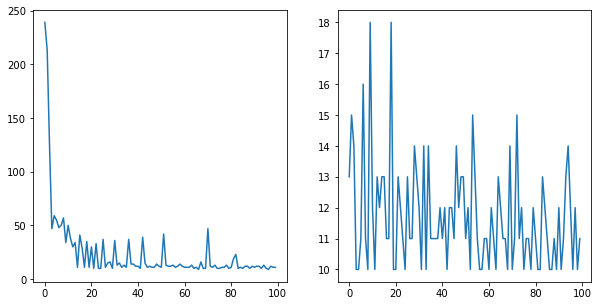

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts[:100])
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[-100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = torch.matmul(w, x)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[0, :])
ax.plot(xtmp1, testq[1, :])
print(w)

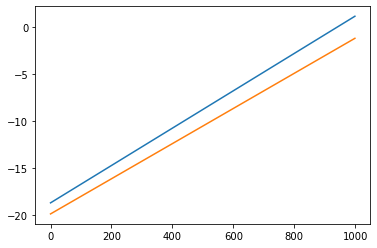

# Gradient SARSA(1) (nn.sequential)

In [27]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2)
)

torch.nn.init.normal_(Q_model[0].weight, 0, 1e-3)
torch.nn.init.normal_(Q_model[2].weight, 0, 1e-3)
print()


In [28]:
obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 0
    terminated = False
    s = env.reset()
    Q_model.zero_grad()
    
    while (terminated is False) :
        
        allq = Q_model(s.squeeze())
        a = ag.select_action(allq)
        q_now = allq[a]

        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = Q_model(s_next.squeeze())
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            Q_model[0].weight -= Q_model[0].weight.grad * alpha
            Q_model[2].weight += Q_model[2].weight.grad * alpha
            Q_model.zero_grad()
        
        s = s_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 1000, t=13
episode 2000, t=11
episode 3000, t=12
episode 4000, t=12


Parameter containing:
tensor([[ 4.2214e-04,  1.2876e-03],
        [-1.3952e-01, -4.9864e-01]], requires_grad=True)
Parameter containing:
tensor([[0.0010, 0.4423],
        [0.0010, 0.0094]], requires_grad=True)


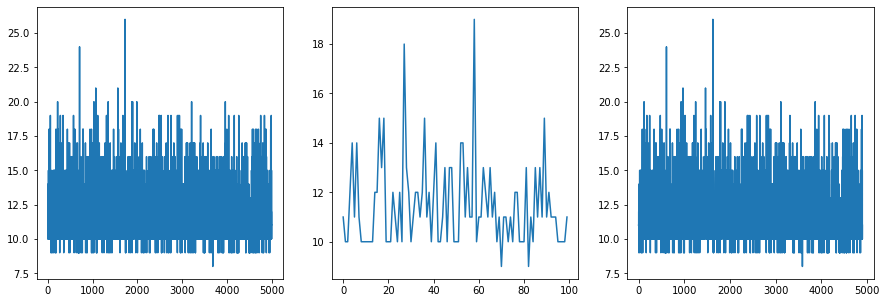

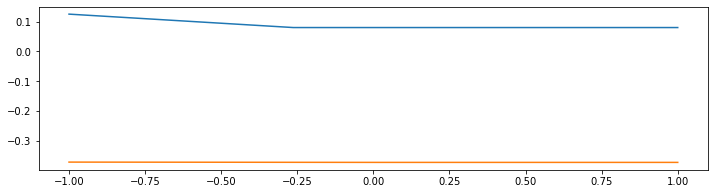

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = Q_model(x.T)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[:, 0])
ax.plot(xtmp1, testq[:, 1])
print(Q_model[0].weight)
print(Q_model[2].weight)

# Sarsa($\lambda$)

In [146]:
def sarsaLamb(ag, env, gamma, alpha, lamb):
    t = 0
    terminated = False
    s, _ = env.reset()
    while (terminated is False) :
        a, q_alla_now = ag.select_action(s)
        ag.ztable[s, a] += 1
        q_now = q_alla_now[a]
        s_next, r_next, terminated, _, _ = env.step(a)
        a_next, all_q_next = ag.select_action(s_next)
        q_next = all_q_next[a_next]
        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now
        ## The commented line below is wrong:
        # ag.qtable[s, a] += alpha * td_err * ag.ztable[s, a]  

        ## The line below is correct. z trace should continually affect the q after the first time step, while 
        ## taking in the TD errors of the subsequent steps.
        ag.qtable += alpha * td_err * ag.ztable

        ag.ztable = gamma * lamb * ag.ztable
        s = s_next
        t += 1
    return t

episode 0, t=0
episode 1000, t=21
episode 2000, t=20
episode 3000, t=25
episode 4000, t=20


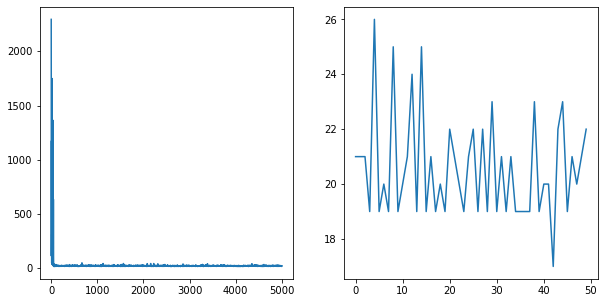

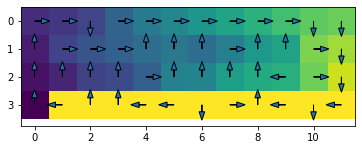

In [138]:
env = gym.make('CliffWalking-v0')
obs_dim = 48
act_dim = 4
gamma = 0.98
lamb = 0.9
alpha = 0.01
epsilon = 0.1
ag = Agent(obs_dim, act_dim, epsilon=epsilon)

ztable = np.zeros((obs_dim, act_dim))

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = sarsaLamb(ag, env, gamma, alpha, lamb)

    all_ts[ni] = t

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[-50:])
fig, ax = plt.subplots()
vis_cliff_walking(ag.qtable, ax)


# Compare

Updated steps for Sarsa(1), Sarsa(N) and Sarsa($\lambda$)

In [139]:
# Custom policy
policy_mat = np.random.randint(0, 4, size=obs_dim)
s_traj = []
a_traj = []
policy_mat[36] = 0
s_traj.append(36)
a_traj.append(0)
for i in range(24, 35):
    policy_mat[i] = 1
    s_traj.append(i)
    a_traj.append(1)
policy_mat[35] = 2
s_traj.append(35)
a_traj.append(2)
# 0: Move up
# 1: Move right
# 2: Move down
# 3: Move left

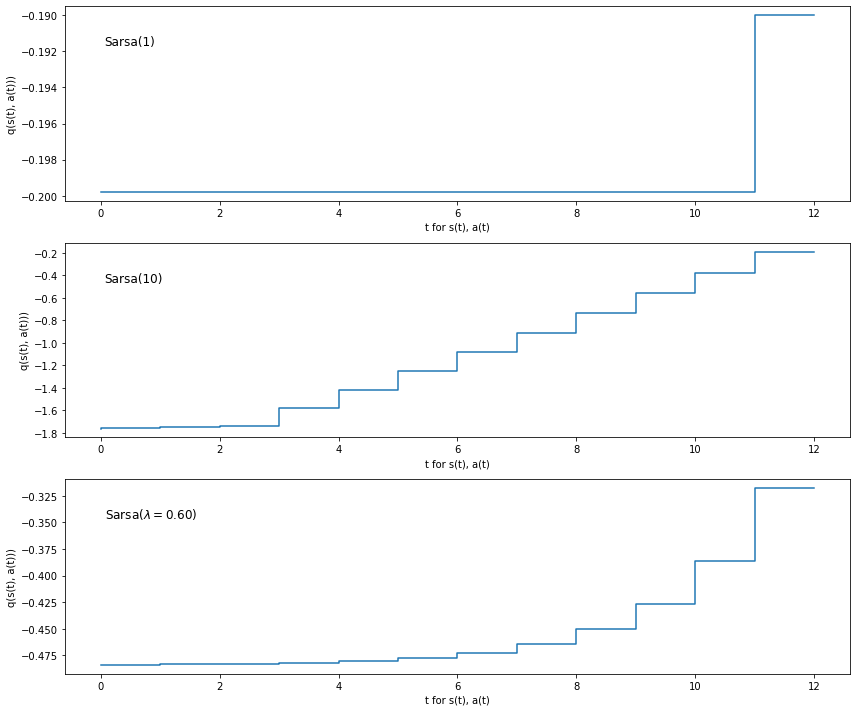

In [164]:

env = gym.make('CliffWalking-v0')
obs_dim = 48
act_dim = 4
gamma = 0.98
alpha = 0.1
lamd = 0.6
ag = Agent(obs_dim, act_dim, epsilon=0, policy='custom', policy_mat=policy_mat)

fig, ax = plt.subplots(3, 1, figsize=(12, 10))

for ai in range(3):
    # if ai == 1:
    #     continue
    Niters = 2
    ag.reset()
    ag.qtable = np.zeros((obs_dim, act_dim))
    q0 = np.array([ag.qtable[s, a] for s, a in zip(s_traj, a_traj)])

    for ni in range(Niters):
        if ai == 0 :
            sarsa1(ag, env, gamma, alpha)
        elif ai == 1:
            sarsaN(ag, env, gamma, alpha, Nstep=10)
        elif ai == 2:
            sarsaLamb(ag, env, gamma, alpha, lamb=lamd)

    q1 = np.array([ag.qtable[s, a] for s, a in zip(s_traj, a_traj)])
    ax[ai].step(x=np.arange(len(s_traj)) , y=q1 - q0)
    ax[ai].set_ylabel('q(s(t), a(t)))')
    ax[ai].set_xlabel('t for s(t), a(t)')

ax[0].annotate('Sarsa(1)', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12)
ax[1].annotate('Sarsa(10)', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12)
ax[2].annotate(r'Sarsa($\lambda=%0.2f$)'%(lamd), xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12)




fig.tight_layout()
